In [1]:
%matplotlib widget
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.loops import from_array
from progress import addjob, ProgressPlot
import threading
import config_qubit as config

2025-10-01 18:32:48,750 - qm - INFO     - Starting session: 63547e22-452e-45cb-a46c-2b822645d8c4


/opt/tljh/user/lib/python3.12/site-packages/qm/results/__init__.py:15: DeprecationWarning: qm.results is deprecated since "1.2.3" and will be removed in "1.3.0". If you need anything from this module, import it directly from `qm` or from `qm.simulate` for simulator-related functionality.
  warnings.warn(


In [3]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-10-01 18:32:52,513 - qm - INFO     - Performing health check
2025-10-01 18:32:52,518 - qm - INFO     - Health check passed


# Connect to the running QM

In [18]:
# Get the## QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1695901731843


# Detection Histograms

In [58]:
# Parameters Definition
n_avg = 60000  # The number of averages
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    I0 = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q0 = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I0_st = declare_stream()  # Stream for the 'I' quadrature
    Q0_st = declare_stream()  # Stream for the 'Q' quadrature
    I1 = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q1 = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I1_st = declare_stream()  # Stream for the 'I' quadrature
    Q1_st = declare_stream()  # Stream for the 'Q' quadrature
    n_st = declare_stream()  # Stream for the averaging iteration 'n'

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
            play("pi", "qubit" )
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I1),
                dual_demod.full("minus_sin", "cos", Q1),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I0),
                dual_demod.full("minus_sin", "cos", Q0),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I0, I0_st)
            save(Q0, Q0_st)
            save(I1, I1_st)
            save(Q1, Q1_st)
            # Save the averaging iteration to get the progress bar
            save(n, n_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I0_st.save_all("I0")
        Q0_st.save_all("Q0")
        I1_st.save_all("I1")
        Q1_st.save_all("Q1")
        n_st.save("iteration")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

2025-10-01 19:14:35,454 - qm - INFO     - Sending program to QOP for compilation

Job is running


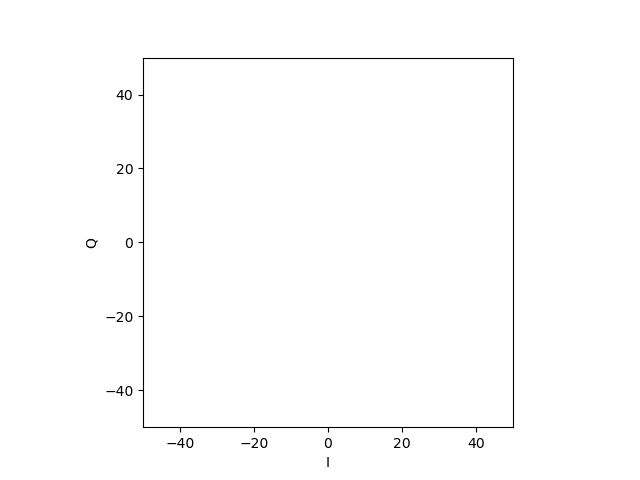

In [59]:
# Real time monitoring and plotting
results = fetching_tool(job, data_list=["I0", "Q0", "I1", "Q1", "iteration"], mode="live")

# Create plot
pp = ProgressPlot()
ax = pp.fig.subplots()
l_IQ0, = ax.plot(np.zeros(n_avg)*np.nan, np.zeros(n_avg)*np.nan,',')
l_IQ1, = ax.plot(np.zeros(n_avg)*np.nan, np.zeros(n_avg)*np.nan,',')
ax.set_xlabel("I")
ax.set_ylabel("Q")
ax.set_aspect("equal")
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)

    
def rot(I,Q,theta):
    theta = theta*np.pi/180
    return I*np.cos(theta)-Q*np.sin(theta) , I*np.sin(theta)+Q*np.cos(theta)

# Real time plot updating
def updatehist(pp, n_avg, job, results, ax, l_IQ0, l_IQ1):
    while results.is_processing():
        # Fetch results
        I0, Q0, I1, Q1, iteration = results.fetch_all()
        # Update plot
        nm = min(len(I0),len(I1),len(Q0),len(Q1))
        I0r, Q0r = rot(I0[:nm]*1e4,Q0[:nm]*1e4,0)
        I1r, Q1r = rot(I1[:nm]*1e4,Q1[:nm]*1e4,0)
        l_IQ0.set_data(I0r,Q0r)
        l_IQ1.set_data(I1r,Q1r)
        # Progress bar
        pp.update(iteration, n_avg)
        # Stop if requested
        if not pp.keeprunning:
            break
    job.halt()    


pp.show()
thread = threading.Thread(target=updatehist, args=(pp, n_avg, job, results, ax, l_IQ0, l_IQ1))
thread.start()

In [52]:
I0,Q0,I1,Q1,n=results.fetch_all()
#np.savez('JPA_o.npz',I0=I0,I1=I1,Q0=Q0,Q1=Q1)

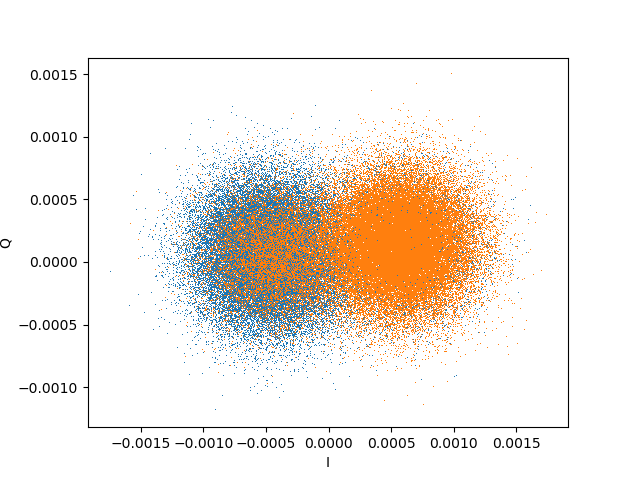

In [41]:
I0r,Q0r = rot(I0,Q0,-45)
I1r,Q1r = rot(I1,Q1,-45)
fig,ax = plt.subplots()
ax.plot(I0r, Q0r,',')
ax.plot(I1r, Q1r,',')
ax.set_xlabel("I")
ax.set_ylabel("Q")
ax.set_aspect("equal")

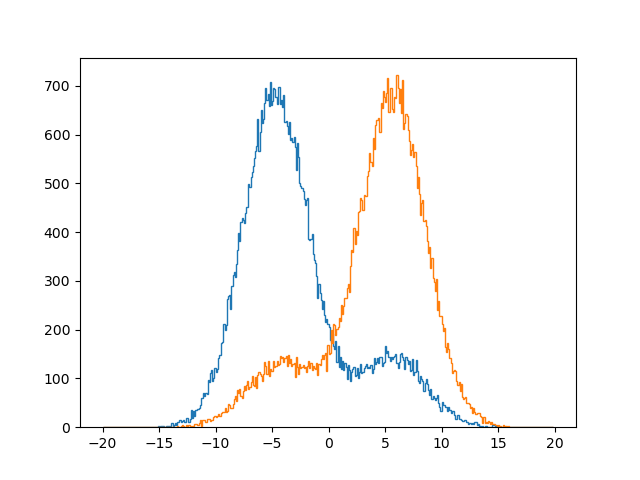

In [55]:
with np.load('JPA_off.npz') as data:
    I0 = data['I0']
    I1 = data['I1']
    Q0 = data['Q0']
    Q1 = data['Q1']
theta = -45*np.pi/180
I0r =  I0*np.cos(theta)-Q0*np.sin(theta)
I1r =  I1*np.cos(theta)-Q1*np.sin(theta)
I0r *= 1e4
I1r *= 1e4
fig,ax=plt.subplots()
bins = np.arange(-20,20,0.1)
ax.hist(I0r,bins,histtype='step')
ax.hist(I1r,bins,histtype='step');

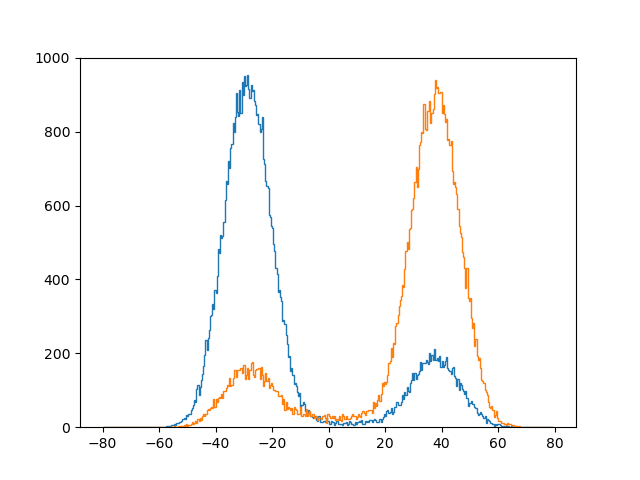

In [57]:
with np.load('JPA_on.npz') as data:
    I0 = data['I0']
    I1 = data['I1']
    Q0 = data['Q0']
    Q1 = data['Q1']
theta = -292*np.pi/180
I0r =  I0*np.cos(theta)-Q0*np.sin(theta)
I1r =  I1*np.cos(theta)-Q1*np.sin(theta)
I0r *= 1e4
I1r *= 1e4
fig,ax=plt.subplots()
bins = np.arange(-80,80,0.4)
ax.hist(I0r,bins,histtype='step')
ax.hist(I1r,bins,histtype='step');

In [88]:
# Parameters Definition
n_meas = 5000  
###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  
    I = declare(fixed)  
    Q = declare(fixed)  
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_meas, n + 1):  # QUA for_ loop for averaging
        measure(
            "readout",
            "resonator",
            dual_demod.full("cos", "sin", I),
            dual_demod.full("minus_sin", "cos", Q),
        )
        save(I, I_st)
        save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.save_all("I")
        Q_st.save_all("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)
results = fetching_tool(job, data_list=["I", "Q"])
I,Q=results.fetch_all()
print("Done")

2025-10-01 19:23:30,685 - qm - INFO     - Sending program to QOP for compilation

Job is running
Done


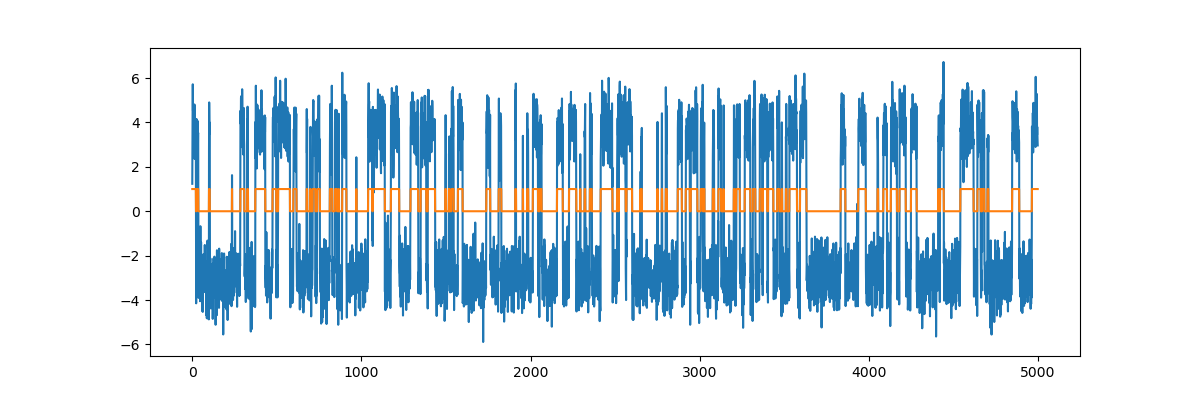

In [90]:
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
Ir *= 1e3
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(Ir)
ax.plot(Ir>.8)

In [99]:
# Parameters Definition
n_meas = 5000  
###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  
    I = declare(fixed)  
    Q = declare(fixed)  
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_meas, n + 1):  # QUA for_ loop for averaging
        play("pi","qubit")
        measure(
            "readout",
            "resonator",
            dual_demod.full("cos", "sin", I),
            dual_demod.full("minus_sin", "cos", Q),
        )
        save(I, I_st)
        save(Q, Q_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.save_all("I")
        Q_st.save_all("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)
results = fetching_tool(job, data_list=["I", "Q"])
I,Q=results.fetch_all()
print("Done")

2025-10-01 19:30:17,853 - qm - INFO     - Sending program to QOP for compilation

Job is running
Done


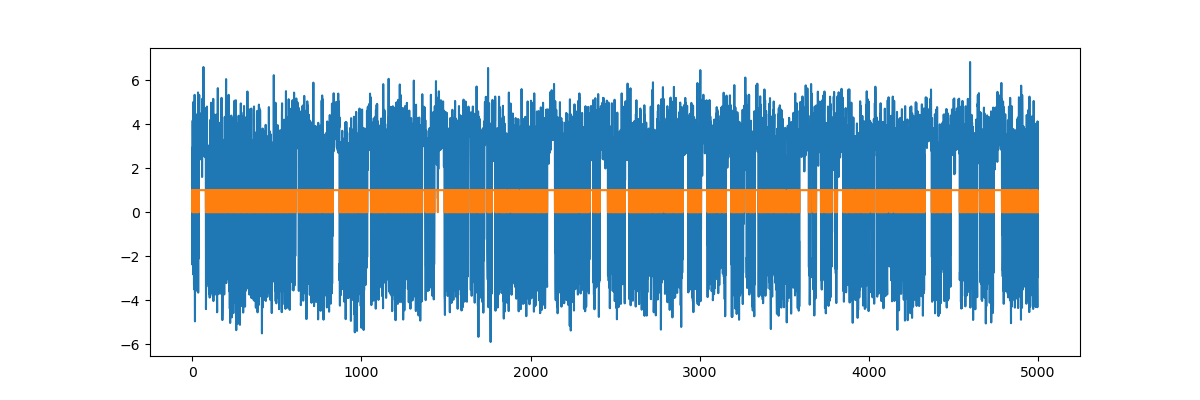

In [100]:
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
Ir *= 1e3
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(Ir)
ax.plot(Ir>.8)

In [103]:
# Parameters Definition
n_meas = 5000  
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  
    I = declare(fixed)  
    Q = declare(fixed)  
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature

    with for_(n, 0, n < n_meas, n + 1):  # QUA for_ loop for averaging
        play("pi_half","qubit")
        measure(
            "readout",
            "resonator",
            dual_demod.full("cos", "sin", I),
            dual_demod.full("minus_sin", "cos", Q),
        )
        save(I, I_st)
        save(Q, Q_st)
        wait(thermalization_time*u.us)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.save_all("I")
        Q_st.save_all("Q")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)
results = fetching_tool(job, data_list=["I", "Q"])
I,Q=results.fetch_all()
print("Done")

2025-10-01 19:31:04,398 - qm - INFO     - Sending program to QOP for compilation

Job is running
Done


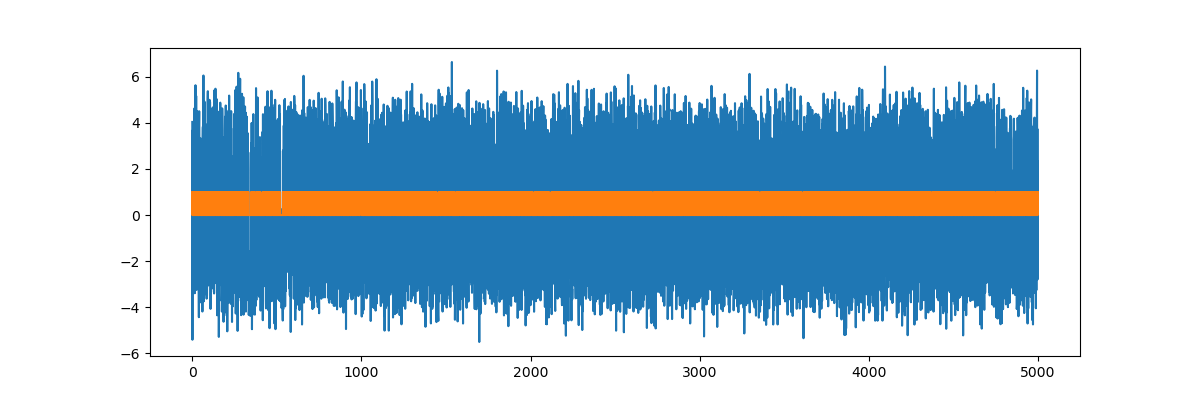

In [104]:
theta = -292*np.pi/180
Ir =  I*np.cos(theta)-Q*np.sin(theta)
Ir *= 1e3
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(Ir)
ax.plot(Ir>.8)